# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

Using TensorFlow backend.


In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
pf1 = portfolio.copy()

In [7]:
dummy = pd.get_dummies(pf1.channels.apply(pd.Series).stack()).sum(level=0)
pf1 = pd.concat([pf1, dummy], axis=1)
pf1 = pf1.drop(columns='channels')

In [8]:
pf1 = pf1.rename(columns={'id':'offer_id'})

In [9]:
## Set offer_id as index
pf1.set_index(keys='offer_id', verify_integrity=True, inplace=True)

In [10]:
## Filter out email column, since it is not an informative feature
pf1.drop(columns=['email', 'difficulty', 'reward'], inplace=True)

In [11]:
# print the result
display(pf1)

,duration,offer_type,mobile,social,web
offer_id,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,7,bogo,1,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,5,bogo,1,1,1
3f207df678b143eea3cee63160fa8bed,4,informational,1,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,7,bogo,1,0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,10,discount,0,0,1
2298d6c36e964ae4a3e7e9706d1fb8c2,7,discount,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,10,discount,1,1,1
5a8bc65990b245e5a138643cd4eb9837,3,informational,1,1,0
f19421c1d4aa40978ebb69ca19b0e20d,5,bogo,1,1,1


In [12]:
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [13]:
pr1 = profile.copy()

In [14]:
pr1 = pr1.rename(columns={'id':'customer_id'})

In [15]:
## Set offer_id as index
pr1.set_index(keys='customer_id', verify_integrity=True, inplace=True)

In [16]:
## Filter out email column, since it is not an informative feature
pr1.drop(columns=['became_member_on'], inplace=True)

In [17]:
pr1.head()

,age,gender,income
customer_id,,,
68be06ca386d4c31939f3a4f0e3dd783,118,None,NaN
0610b486422d4921ae7d2bf64640c50b,55,F,112000.0
38fe809add3b4fcf9315a9694bb96ff5,118,None,NaN
78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0
a03223e636434f42ac4c3df47e8bac43,118,None,NaN


In [18]:
pr1.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [21]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [22]:
tc1 = transcript.copy()

In [23]:
tc1 = tc1.rename(columns={'person':'customer_id'})

In [24]:
tc1['event'] = tc1['event'].str.replace(' ', '-')

In [25]:
tc1['event'].value_counts()

transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: event, dtype: int64

In [26]:
dummy = pd.get_dummies(tc1['event'])
tc1 = pd.concat([tc1, dummy], axis=1 )

In [27]:
tc1.head()

,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer-received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer-received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer-received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer-received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [28]:
tc1['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in tc1.value]
tc1['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in tc1.value]

In [29]:
tc1 = tc1.drop(columns=['value', 'event'])

In [30]:
tc1.head()

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [31]:
dfm1 = pd.merge(tc1, pr1, on='customer_id')

In [32]:
dfm2 = pd.merge(dfm1, pf1, on='offer_id', how='left')
dfm2.head()

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,gender,income,duration,offer_type,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89,75,F,100000.0,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78,75,F,100000.0,NaN,NaN,NaN,NaN,NaN


In [33]:
offer_id = dfm2['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', None,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [34]:
offer_dict = pd.Series(offer_id).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: None,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: '2906b810c7d4411798c6938adc9daaa5',
 8: 'fafdcd668e3743c1bb461111dcafc2a4',
 9: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 10: '2298d6c36e964ae4a3e7e9706d1fb8c2'}

In [35]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [36]:
dfm2['offer_id'] = dfm2['offer_id'].map(offer_dict)

In [37]:
dfm2['offer_id'] = dfm2['offer_id'].replace(1, np.nan)

In [38]:
dfm2.head()

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,gender,income,duration,offer_type,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,F,100000.0,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,F,100000.0,NaN,NaN,NaN,NaN,NaN


In [39]:
dfm2['offer_id'].unique()

array([  0.,  nan,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [40]:
dfm2.head()

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,gender,income,duration,offer_type,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,F,100000.0,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,F,100000.0,NaN,NaN,NaN,NaN,NaN


In [41]:
dfm2.shape

(306534, 16)

In [42]:
dfm2.columns

Index(['customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'age', 'gender',
       'income', 'duration', 'offer_type', 'mobile', 'social', 'web'],
      dtype='object')

In [43]:
dfm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 16 columns):
customer_id        306534 non-null object
time               306534 non-null int64
offer-completed    306534 non-null uint8
offer-received     306534 non-null uint8
offer-viewed       306534 non-null uint8
transaction        306534 non-null uint8
offer_id           167581 non-null float64
amount             138953 non-null float64
age                306534 non-null int64
gender             272762 non-null object
income             272762 non-null float64
duration           167581 non-null float64
offer_type         167581 non-null object
mobile             167581 non-null float64
social             167581 non-null float64
web                167581 non-null float64
dtypes: float64(7), int64(2), object(3), uint8(4)
memory usage: 31.6+ MB


In [44]:
dfm2.head()

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,gender,income,duration,offer_type,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,F,100000.0,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,F,100000.0,NaN,NaN,NaN,NaN,NaN


In [45]:
dfm2['offer_type'].value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [46]:
dfm2_complete = dfm2.copy()

In [47]:
index_names = dfm2_complete[ dfm2_complete['offer-completed'] == 0 ].index
dfm2_complete.drop(index_names, inplace = True)

In [48]:
dfm2_complete

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,gender,income,duration,offer_type,mobile,social,web
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
14,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,0,3.0,NaN,75,F,100000.0,7.0,bogo,1.0,1.0,0.0
15,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,0,4.0,NaN,75,F,100000.0,5.0,bogo,1.0,1.0,1.0
39,e2127556f4f64592b11af22de27a7932,522,1,0,0,0,0.0,NaN,68,M,70000.0,7.0,bogo,1.0,0.0,1.0
40,e2127556f4f64592b11af22de27a7932,522,1,0,0,0,8.0,NaN,68,M,70000.0,10.0,discount,1.0,1.0,1.0
65,389bc3fa690240e798340f5a15918d5c,60,1,0,0,0,4.0,NaN,65,M,53000.0,5.0,bogo,1.0,1.0,1.0
73,389bc3fa690240e798340f5a15918d5c,498,1,0,0,0,7.0,NaN,65,M,53000.0,7.0,discount,1.0,0.0,1.0
74,389bc3fa690240e798340f5a15918d5c,498,1,0,0,0,0.0,NaN,65,M,53000.0,7.0,bogo,1.0,0.0,1.0
80,389bc3fa690240e798340f5a15918d5c,600,1,0,0,0,4.0,NaN,65,M,53000.0,5.0,bogo,1.0,1.0,1.0
81,389bc3fa690240e798340f5a15918d5c,600,1,0,0,0,8.0,NaN,65,M,53000.0,10.0,discount,1.0,1.0,1.0


In [49]:
dfm2_complete["time"] = dfm2_complete["time"] / 24

In [50]:
dfm2_complete

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,gender,income,duration,offer_type,mobile,social,web
3,78afa995795e4d85b5d9ceeca43f5fef,5.50,1,0,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0
14,78afa995795e4d85b5d9ceeca43f5fef,21.25,1,0,0,0,3.0,NaN,75,F,100000.0,7.0,bogo,1.0,1.0,0.0
15,78afa995795e4d85b5d9ceeca43f5fef,21.25,1,0,0,0,4.0,NaN,75,F,100000.0,5.0,bogo,1.0,1.0,1.0
39,e2127556f4f64592b11af22de27a7932,21.75,1,0,0,0,0.0,NaN,68,M,70000.0,7.0,bogo,1.0,0.0,1.0
40,e2127556f4f64592b11af22de27a7932,21.75,1,0,0,0,8.0,NaN,68,M,70000.0,10.0,discount,1.0,1.0,1.0
65,389bc3fa690240e798340f5a15918d5c,2.50,1,0,0,0,4.0,NaN,65,M,53000.0,5.0,bogo,1.0,1.0,1.0
73,389bc3fa690240e798340f5a15918d5c,20.75,1,0,0,0,7.0,NaN,65,M,53000.0,7.0,discount,1.0,0.0,1.0
74,389bc3fa690240e798340f5a15918d5c,20.75,1,0,0,0,0.0,NaN,65,M,53000.0,7.0,bogo,1.0,0.0,1.0
80,389bc3fa690240e798340f5a15918d5c,25.00,1,0,0,0,4.0,NaN,65,M,53000.0,5.0,bogo,1.0,1.0,1.0
81,389bc3fa690240e798340f5a15918d5c,25.00,1,0,0,0,8.0,NaN,65,M,53000.0,10.0,discount,1.0,1.0,1.0


In [51]:
dfm2_complete['condition'] = np.where(dfm2_complete['time'] <= dfm2_complete['duration'], True, False)
dfm2_complete.head()

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,gender,income,duration,offer_type,mobile,social,web,condition
3,78afa995795e4d85b5d9ceeca43f5fef,5.50,1,0,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0,True
14,78afa995795e4d85b5d9ceeca43f5fef,21.25,1,0,0,0,3.0,NaN,75,F,100000.0,7.0,bogo,1.0,1.0,0.0,False
15,78afa995795e4d85b5d9ceeca43f5fef,21.25,1,0,0,0,4.0,NaN,75,F,100000.0,5.0,bogo,1.0,1.0,1.0,False
39,e2127556f4f64592b11af22de27a7932,21.75,1,0,0,0,0.0,NaN,68,M,70000.0,7.0,bogo,1.0,0.0,1.0,False
40,e2127556f4f64592b11af22de27a7932,21.75,1,0,0,0,8.0,NaN,68,M,70000.0,10.0,discount,1.0,1.0,1.0,False


In [52]:
index_names2 = dfm2_complete[ dfm2_complete['condition'] == False ].index
dfm2_complete.drop(index_names2, inplace = True)

In [53]:
dfm2_complete.head()

,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,gender,income,duration,offer_type,mobile,social,web,condition
3,78afa995795e4d85b5d9ceeca43f5fef,5.50,1,0,0,0,0.0,NaN,75,F,100000.0,7.0,bogo,1.0,0.0,1.0,True
65,389bc3fa690240e798340f5a15918d5c,2.50,1,0,0,0,4.0,NaN,65,M,53000.0,5.0,bogo,1.0,1.0,1.0,True
188,4b0da7e80e5945209a1fdddfe813dbe0,7.50,1,0,0,0,5.0,NaN,64,M,100000.0,10.0,discount,0.0,0.0,1.0,True
226,d53717f5400c4e84affdaeda9dd926b3,1.25,1,0,0,0,5.0,NaN,88,F,53000.0,10.0,discount,0.0,0.0,1.0,True
243,f806632c011441378d4646567f357a21,5.25,1,0,0,0,8.0,NaN,42,M,69000.0,10.0,discount,1.0,1.0,1.0,True


In [54]:
dfm2_complete['offer_type'].value_counts()

discount    3532
bogo        2349
Name: offer_type, dtype: int64

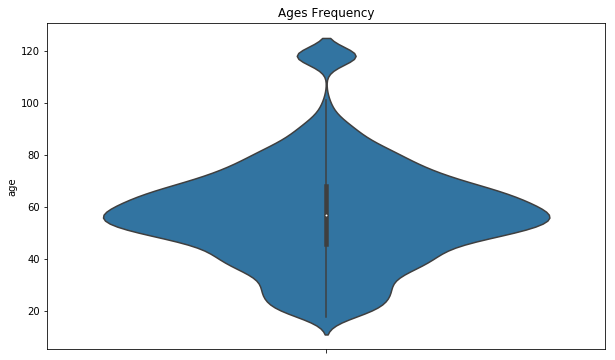

In [55]:
plt.figure(figsize=(10,6))
plt.title("Ages Frequency")
sns.axes_style("dark")
sns.violinplot(y=dfm2_complete["age"])
plt.show()

In [56]:
dfm2_bogo = dfm2_complete.copy()

In [57]:
dfm2_bogo=dfm2_bogo.drop(['customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'duration', 'mobile', 'social', 'web','condition'],axis=1)

In [58]:
dfm2_bogo.head()

,age,gender,income,offer_type
3,75,F,100000.0,bogo
65,65,M,53000.0,bogo
188,64,M,100000.0,discount
226,88,F,53000.0,discount
243,42,M,69000.0,discount


In [59]:
index_discount = dfm2_bogo[dfm2_bogo['offer_type'] == 'discount'].index
dfm2_bogo.drop(index_discount, inplace = True)

In [60]:
dfm2_bogo

,age,gender,income,offer_type
3,75,F,100000.0,bogo
65,65,M,53000.0,bogo
366,40,M,33000.0,bogo
392,69,F,57000.0,bogo
482,75,M,40000.0,bogo
515,45,M,33000.0,bogo
659,37,M,92000.0,bogo
710,73,M,38000.0,bogo
734,78,F,93000.0,bogo
758,44,M,35000.0,bogo


In [61]:
dfm2_bogo=dfm2_bogo.drop(['offer_type'],axis=1)

In [62]:
dfm2_bogo.head()

,age,gender,income
3,75,F,100000.0
65,65,M,53000.0
366,40,M,33000.0
392,69,F,57000.0
482,75,M,40000.0


In [63]:
dfm2_bogo.describe()

,age,income
count,2349.000000,2303.000000
mean,56.839932,70234.910986
std,18.652952,21809.198606
min,18.000000,30000.000000
25%,45.000000,54000.000000
50%,56.000000,69000.000000
75%,68.000000,86000.000000
max,118.000000,120000.000000


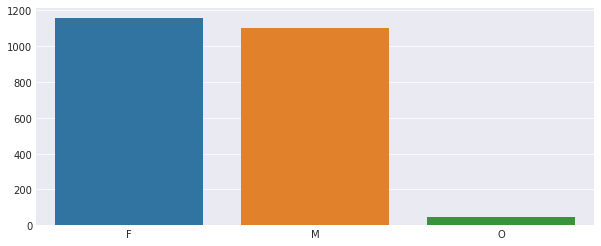

In [64]:
gender = dfm2_bogo.gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=gender.index, y=gender.values)
plt.show()

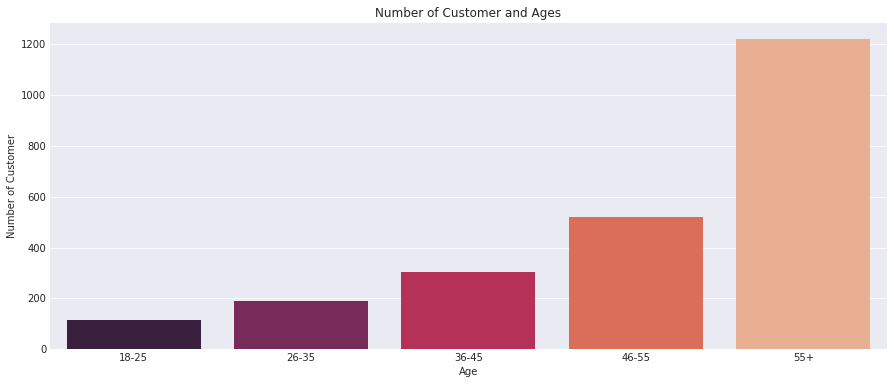

In [65]:
age18_25 = dfm2_bogo.age[(dfm2_bogo.age <= 25) & (dfm2_bogo.age >= 18)]
age26_35 = dfm2_bogo.age[(dfm2_bogo.age <= 35) & (dfm2_bogo.age >= 26)]
age36_45 = dfm2_bogo.age[(dfm2_bogo.age <= 45) & (dfm2_bogo.age >= 36)]
age46_55 = dfm2_bogo.age[(dfm2_bogo.age <= 55) & (dfm2_bogo.age >= 46)]
age55above = dfm2_bogo.age[dfm2_bogo.age >= 56]

x = ["18-25","26-35","36-45","46-55","55+"]
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Number of Customer and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.show()

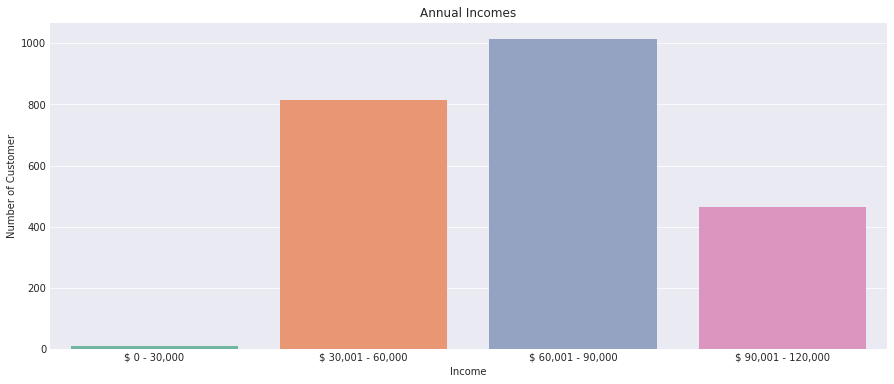

In [66]:
ai0_30 = dfm2_bogo["income"][(dfm2_bogo["income"] >= 0) & (dfm2_bogo["income"] <= 30000)]
ai31_60 = dfm2_bogo["income"][(dfm2_bogo["income"] >= 31000) & (dfm2_bogo["income"] <= 60000)]
ai61_90 = dfm2_bogo["income"][(dfm2_bogo["income"] >= 61000) & (dfm2_bogo["income"] <= 90000)]
ai91_120 = dfm2_bogo["income"][(dfm2_bogo["income"] >= 91000) & (dfm2_bogo["income"] <= 120000)]

aix = ["$ 0 - 30,000", "$ 30,001 - 60,000", "$ 60,001 - 90,000", "$ 90,001 - 120,000"]
aiy = [len(ai0_30.values), len(ai31_60.values), len(ai61_90.values), len(ai91_120.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=aix, y=aiy, palette="Set2")
plt.title("Annual Incomes")
plt.xlabel("Income")
plt.ylabel("Number of Customer")
plt.show()

In [67]:
gender_id = dfm2_bogo['gender'].unique()
gender_id

array(['F', 'M', 'O', None], dtype=object)

In [68]:
gender_dict = pd.Series(gender_id).to_dict()
gender_dict

{0: 'F', 1: 'M', 2: 'O', 3: None}

In [69]:
gender_dict = dict([(value, key) for key, value in gender_dict.items()]) 
gender_dict

{'F': 0, 'M': 1, 'O': 2, None: 3}

In [70]:
dfm2_bogo['gender'].replace(gender_dict, inplace = True)

In [71]:
dfm2_bogo = dfm2_bogo[dfm2_bogo.gender != 3]

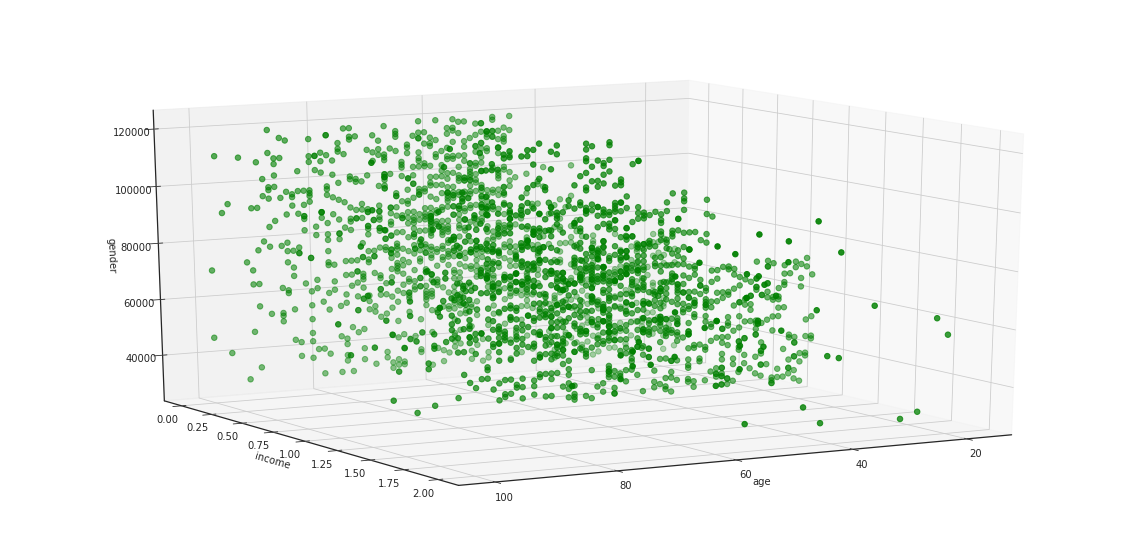

In [72]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfm2_bogo.age, dfm2_bogo["gender"], dfm2_bogo["income"], c='green', s=30)
ax.view_init(15, 60)
plt.xlabel("age")
plt.ylabel("income")
ax.set_zlabel('gender')
plt.show()

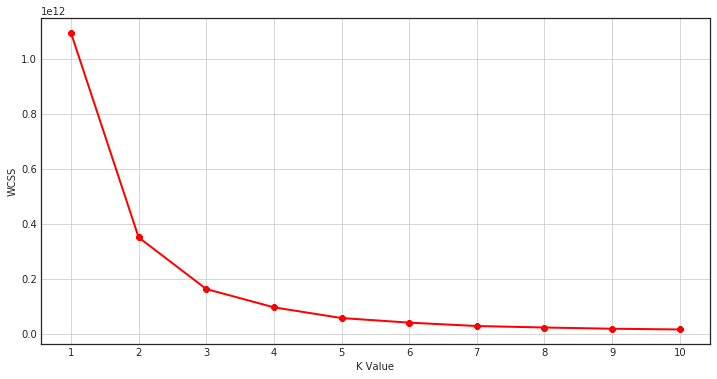

In [73]:
from sklearn.cluster import KMeans

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(dfm2_bogo.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [74]:
#dfm2_bogo["gender"]=((dfm2_bogo["gender"]-dfm2_bogo["gender"].min())/(dfm2_bogo["gender"].max()-dfm2_bogo["gender"].min()))*10

In [75]:
#dfm2_bogo["income"]=((dfm2_bogo["income"]-dfm2_bogo["income"].min())/(dfm2_bogo["income"].max()-dfm2_bogo["income"].min()))*10

In [76]:
#dfm2_bogo["age"]=((dfm2_bogo["age"]-dfm2_bogo["age"].min())/(dfm2_bogo["age"].max()-dfm2_bogo["age"].min()))*10

In [77]:
#dfm2_bogo

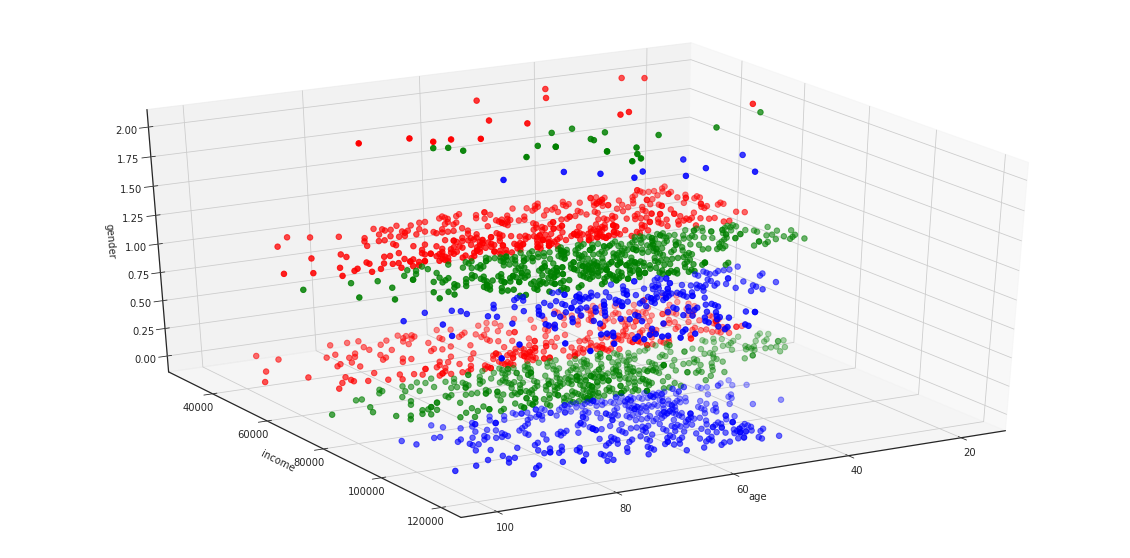

In [78]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(dfm2_bogo.iloc[:,1:])

dfm2_bogo["label"] = clusters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfm2_bogo.age[dfm2_bogo.label == 0], dfm2_bogo["income"][dfm2_bogo.label == 0], dfm2_bogo["gender"][dfm2_bogo.label == 0], c='blue', s=30)
ax.scatter(dfm2_bogo.age[dfm2_bogo.label == 1], dfm2_bogo["income"][dfm2_bogo.label == 1], dfm2_bogo["gender"][dfm2_bogo.label == 1], c='red', s=30)
ax.scatter(dfm2_bogo.age[dfm2_bogo.label == 2], dfm2_bogo["income"][dfm2_bogo.label == 2], dfm2_bogo["gender"][dfm2_bogo.label == 2], c='green', s=30)

ax.view_init(30, 60)
plt.xlabel("age")
plt.ylabel("income")
ax.set_zlabel('gender')
plt.show()

In [79]:
dfm2_discount = dfm2_complete.copy()

In [80]:
dfm2_discount=dfm2_discount.drop(['customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'duration', 'mobile', 'social', 'web','condition'],axis=1)

In [81]:
index_bogo = dfm2_discount[dfm2_discount['offer_type'] == 'bogo'].index
dfm2_discount.drop(index_bogo, inplace = True)

In [82]:
dfm2_discount['offer_type'].value_counts()

discount    3532
Name: offer_type, dtype: int64

In [83]:
dfm2_discount=dfm2_discount.drop(['offer_type'],axis=1)

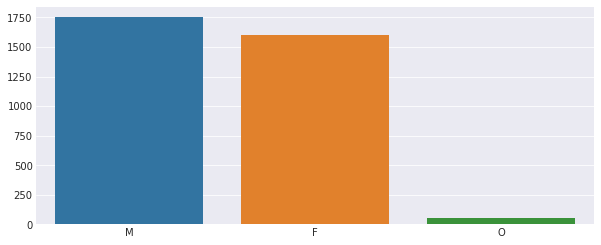

In [84]:
gender = dfm2_discount.gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=gender.index, y=gender.values)
plt.show()

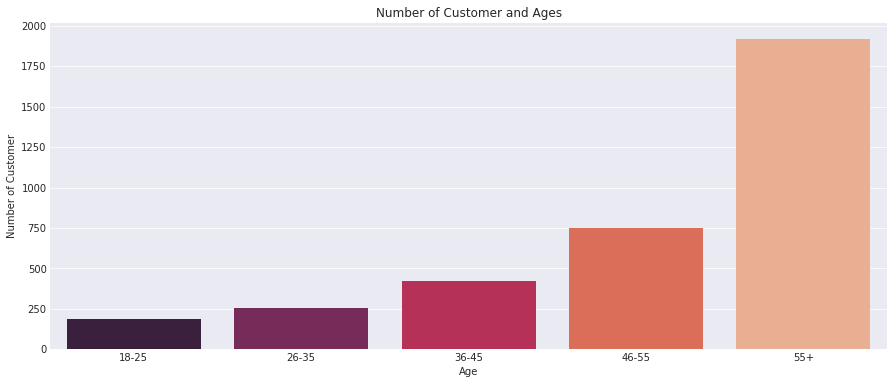

In [85]:
age18_25 = dfm2_discount.age[(dfm2_discount.age <= 25) & (dfm2_discount.age >= 18)]
age26_35 = dfm2_discount.age[(dfm2_discount.age <= 35) & (dfm2_discount.age >= 26)]
age36_45 = dfm2_discount.age[(dfm2_discount.age <= 45) & (dfm2_discount.age >= 36)]
age46_55 = dfm2_discount.age[(dfm2_discount.age <= 55) & (dfm2_discount.age >= 46)]
age55above = dfm2_discount.age[dfm2_discount.age >= 56]

x = ["18-25","26-35","36-45","46-55","55+"]
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Number of Customer and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.show()

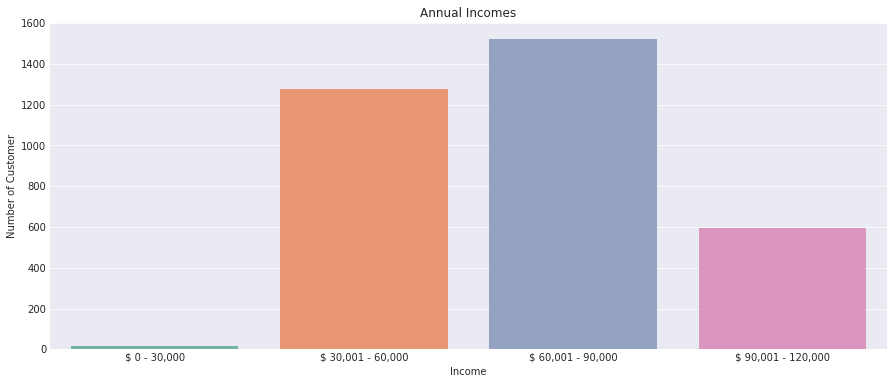

In [86]:
ai0_30 = dfm2_discount["income"][(dfm2_discount["income"] >= 0) & (dfm2_discount["income"] <= 30000)]
ai31_60 = dfm2_discount["income"][(dfm2_discount["income"] >= 31000) & (dfm2_discount["income"] <= 60000)]
ai61_90 = dfm2_discount["income"][(dfm2_discount["income"] >= 61000) & (dfm2_discount["income"] <= 90000)]
ai91_120 = dfm2_discount["income"][(dfm2_discount["income"] >= 91000) & (dfm2_discount["income"] <= 120000)]

aix = ["$ 0 - 30,000", "$ 30,001 - 60,000", "$ 60,001 - 90,000", "$ 90,001 - 120,000"]
aiy = [len(ai0_30.values), len(ai31_60.values), len(ai61_90.values), len(ai91_120.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=aix, y=aiy, palette="Set2")
plt.title("Annual Incomes")
plt.xlabel("Income")
plt.ylabel("Number of Customer")
plt.show()

In [87]:
gender_id = dfm2_discount['gender'].unique()
gender_id

array(['M', 'F', None, 'O'], dtype=object)

In [88]:
gender_dict = pd.Series(gender_id).to_dict()
gender_dict

{0: 'M', 1: 'F', 2: None, 3: 'O'}

In [89]:
gender_dict = dict([(value, key) for key, value in gender_dict.items()]) 
gender_dict

{'M': 0, 'F': 1, None: 2, 'O': 3}

In [90]:
dfm2_discount['gender'].replace(gender_dict, inplace = True)

In [91]:
dfm2_discount = dfm2_discount[dfm2_discount.gender != 2]

In [92]:
dfm2_discount.gender.value_counts()

0    1752
1    1601
3      57
Name: gender, dtype: int64

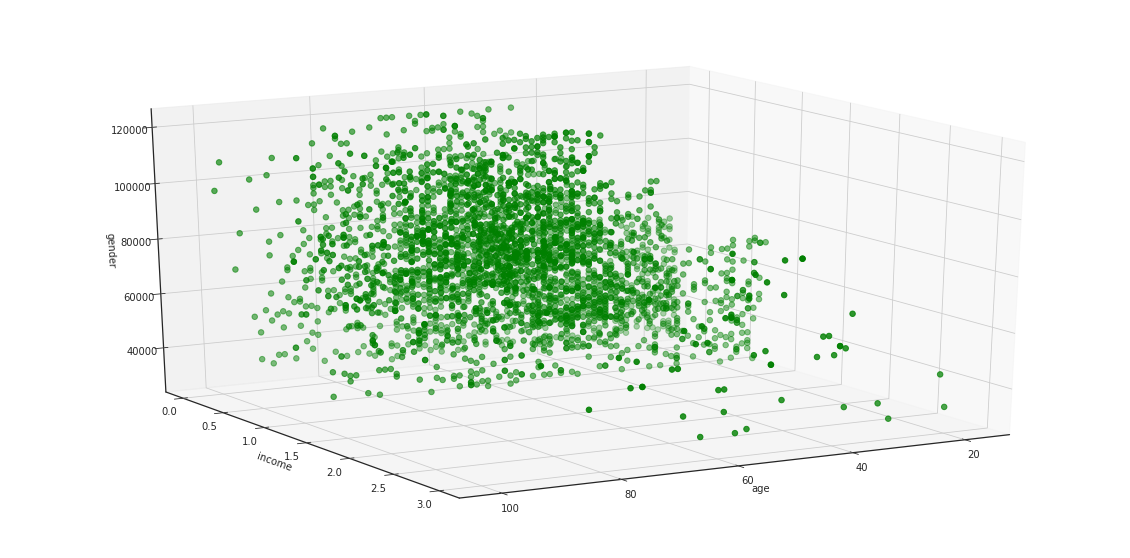

In [93]:
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfm2_discount.age, dfm2_discount["gender"], dfm2_discount["income"], c='green', s=30)
ax.view_init(20, 60)
plt.xlabel("age")
plt.ylabel("income")
ax.set_zlabel('gender')
plt.show()

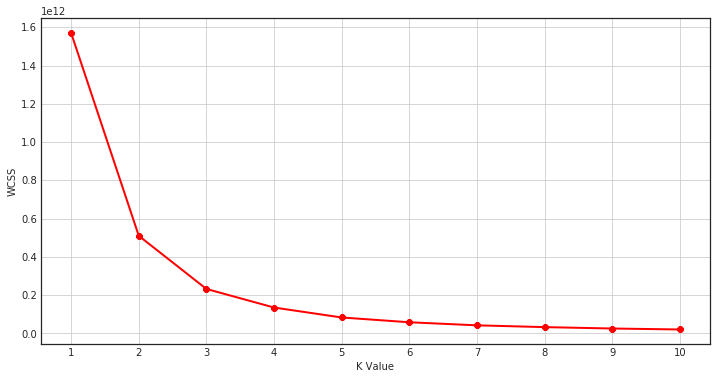

In [94]:
from sklearn.cluster import KMeans

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(dfm2_discount.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

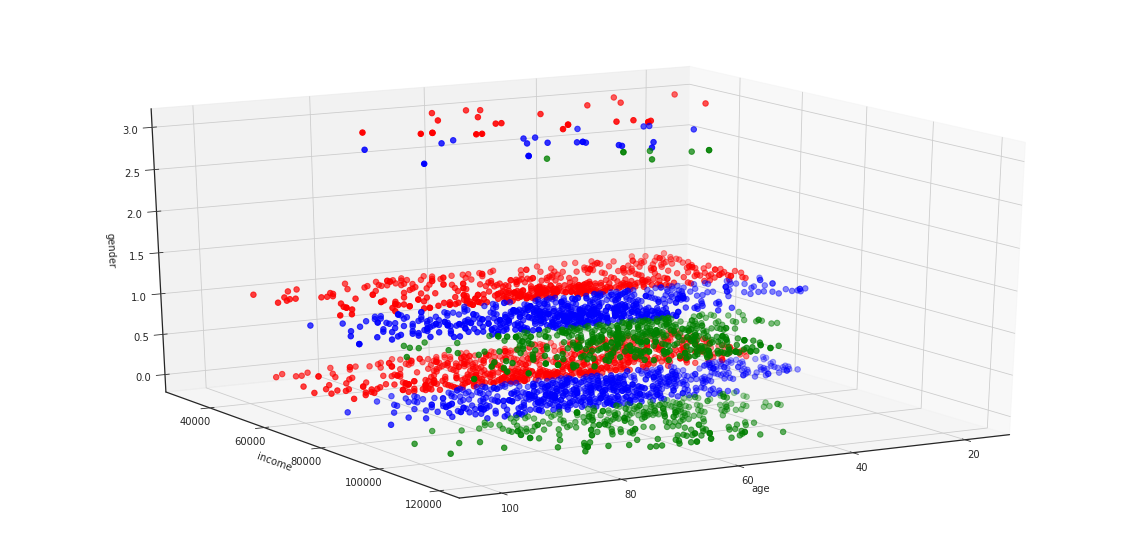

In [95]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(dfm2_discount.iloc[:,1:])

dfm2_discount["label"] = clusters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfm2_discount.age[dfm2_discount.label == 0], dfm2_discount["income"][dfm2_discount.label == 0], dfm2_discount["gender"][dfm2_discount.label == 0], c='blue', s=30)
ax.scatter(dfm2_discount.age[dfm2_discount.label == 1], dfm2_discount["income"][dfm2_discount.label == 1], dfm2_discount["gender"][dfm2_discount.label == 1], c='red', s=30)
ax.scatter(dfm2_discount.age[dfm2_discount.label == 2], dfm2_discount["income"][dfm2_discount.label == 2], dfm2_discount["gender"][dfm2_discount.label == 2], c='green', s=30)

ax.view_init(20, 60)
plt.xlabel("age")
plt.ylabel("income")
ax.set_zlabel('gender')
plt.show()